# Fit Halo Mass from a Shear Catalog

_the LSST-DESC CLMM team_


This notebook demonstrates how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster.

## Setup

First, we import some standard packages.

In [530]:
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
from numpy import random
from scipy import optimize as spo
import sys

Next, we import `clmm`'s core modules.

In [531]:
import clmm
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.
We also provide support modules for processing other specific data sets for use with `clmm`.
Any existing support module can be used as a template for creating a new support module for another data set.
If you do make such a support module, please do consider making a pull request so we can add it for others to use.

In [532]:
sys.path.append('./support')
import mock_data as mock

## Making mock data

To create mock data, we need to define a true cosmology, which is currently done with [`astropy`'s cosmology library](http://docs.astropy.org/en/stable/cosmology/index.html).

In [533]:
mock_cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)

We now set some parameters for a mock galaxy cluster.

In [534]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15
cluster_z = 0.3
concentration = 4
ngals = 5000
Delta = 200
cluster_ra = 0.0
cluster_dec = 0.0

Then we use the `mock_data` support module to generate a new galaxy catalog. It includes sources distributed in redshift according to the Chang et al. (2013) distribution, with photometric redshift errors, and noise in the shape measurements. 

In [535]:
noisy_data_z = mock.generate_galaxy_catalog(cluster_m,
                                            cluster_z,
                                            concentration,
                                            cosmo,
                                            ngals,
                                            Delta,
                                            'uniform',
                                            shapenoise=0.04,
                                            photoz_sigma_unscaled=0.05)

# noisy_data_z = mock.generate_galaxy_catalog(cluster_m,
#                                             cluster_z,
#                                             concentration,
#                                             cosmo,
#                                             ngals,
#                                             Delta,
#                                             'chang13',
#                                             shapenoise=0.04,
#                                             photoz_sigma_unscaled=0.05)

This galaxy catalog is then converted to a `clmm.GalaxyCluster` object.

In [536]:
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, noisy_data_z)

A `clmm.GalaxyCluster` object can be pickled and saved for later use.

In [537]:
gc_object.save('mock_GC.pkl')

Any saved `clmm.GalaxyCluster` object may be read in for analysis.

In [538]:
cl = clmm.load_cluster('mock_GC.pkl')
print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra, "; dec:", cl.dec, "; z_l :", cl.z)
print("The number of source galaxies is :", len(cl.galcat))

ra_l = cl.ra
dec_l = cl.dec
z = cl.z
e1 = cl.galcat['e1']
e2 = cl.galcat['e2']
ra_s = cl.galcat['ra']
dec_s = cl.galcat['dec']

Cluster info = ID: Awesome_cluster ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 5000


We can visualize the distribution of galaxies on the sky.

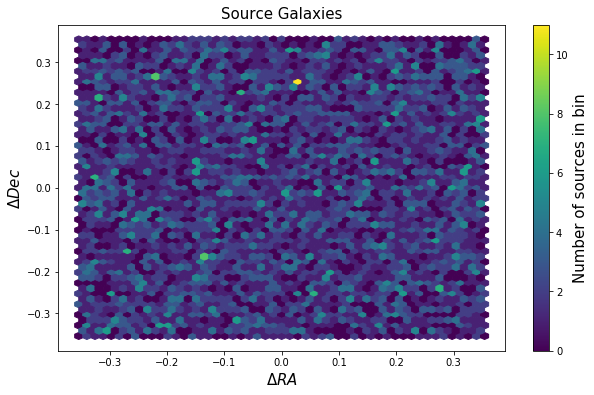

In [539]:
fsize = 15

fig = plt.figure(figsize=(10, 6))
hb = fig.gca().hexbin(ra_s, dec_s, gridsize=50)

cb = fig.colorbar(hb)
cb.set_label('Number of sources in bin', fontsize=fsize)

plt.gca().set_xlabel(r'$\Delta RA$', fontsize=fsize)
plt.gca().set_ylabel(r'$\Delta Dec$', fontsize=fsize)
plt.gca().set_title('Source Galaxies', fontsize=fsize)

plt.show()

`clmm` separates cosmology-dependent and cosmology-independent functionality.

## Deriving observables

We first demonstrate a few of the procedures one can perform on data without assuming a cosmology.

### Computing shear

`clmm.polaraveraging.compute_shear` calculates the tangential and cross shears for each source galaxy in the cluster.

In [540]:
theta, g_t, g_x = pa.compute_shear(cl, geometry="flat")

We can visualize the shear field at each galaxy location.

Text(0.5,0,'angular distance [rad]')

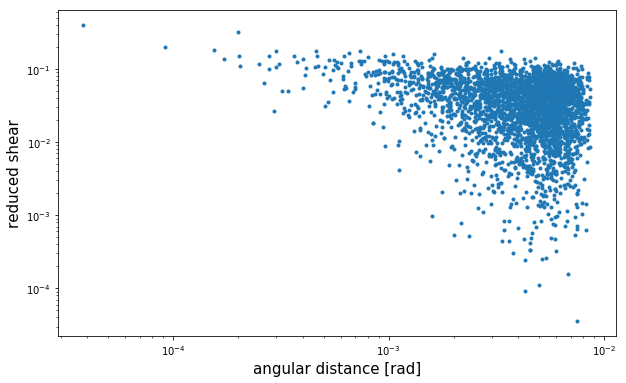

In [541]:
fig = plt.figure(figsize=(10, 6))

fig.gca().loglog(theta, g_t, '.')
plt.ylabel("reduced shear", fontsize=fsize)
plt.xlabel("angular distance [rad]", fontsize=fsize)

### Radially binning the data

Here we compare the reconstructed mass under two different bin definitions.

In [542]:
bin_edges = pa.make_bins(0.7, 4, 20, method='evenlog10width')

`clmm.polaraveraging.make_shear_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [543]:
profile = pa.make_shear_profile(cl, "radians", "Mpc", bins=bin_edges,cosmo=cosmo)

In [544]:
cl.profile

radius_min,radius,radius_max,gt,gt_err,gx,gx_err,z,z_err
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.7,0.7400769106702209,0.7637410563951585,0.07312120112156574,0.005791520020325599,9.926473223645063e-18,4.208705721278592e-18,4.470312255319619,0.2623567375606361
0.7637410563951585,0.7983380633299386,0.8332862874622755,0.0593068917984773,0.0026902578194843074,-4.3259666682171625e-18,1.1902984544257143e-18,2.9027954455681293,0.18874340176285176
0.8332862874622755,0.8759184738285518,0.9091642135229115,0.07356221770446086,0.002000238724412927,-1.9219947603152124e-19,1.6226838199324883e-18,3.50998496798958,0.07847943886344148
0.9091642135229115,0.9505656281031853,0.99195148124666,0.07870354135437918,0.002231721663983683,-5.134016169710771e-19,3.026180472556638e-19,3.4665354032015316,0.10550128615864136
0.99195148124666,1.0379549984843413,1.0822772459715235,0.06491346811510242,0.0014471002448983381,1.736659551284817e-18,3.7745612830771434e-19,3.653293459707332,0.05877381232458377
1.0822772459715235,1.1342931951891468,1.1808279530724777,0.05348224581220634,0.0017609476192940563,-3.0531133177191805e-18,4.972936360330659e-19,3.3945244798777092,0.09004582161236092
1.1808279530724777,1.2438695718342643,1.2883525547150096,0.05389034446936528,0.0013300148726362617,2.019326546254252e-18,3.8683854960919736e-19,3.6153440011633133,0.06519041993311063
1.2883525547150096,1.3443216149710373,1.4056682016392041,0.044324003094332605,0.0011623312639584015,-5.227403331626539e-18,6.669686964215779e-19,3.7402669054948308,0.06405923652877937
1.4056682016392041,1.4715174409522094,1.5336664532300124,0.04465517792083058,0.0008772507404596456,1.959746568379459e-18,2.369800520420711e-19,3.298260540949836,0.03531510924065312


For later use, we'll define some variables for the binned radius and tangential shear.

We visualize the radially binned shear for our mock galaxies.

Text(0,0.5,'$g_t$')

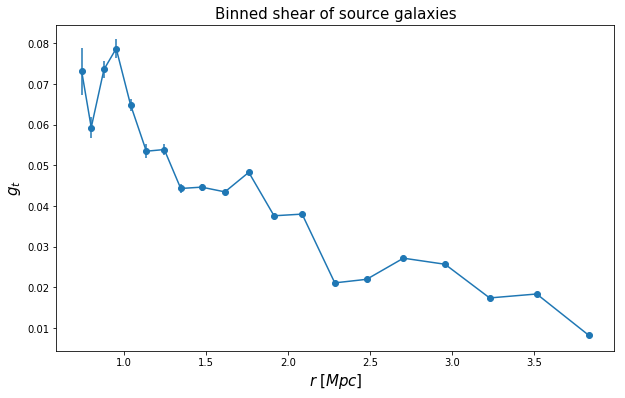

In [545]:
fig = plt.figure(figsize=(10, 6))

fig.gca().errorbar(profile['radius'], profile['gt'], yerr=profile['gt_err'], marker='o')

plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;[Mpc]$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)

After running `clmm.polaraveraging.make_shear_profile` on a `clmm.GalaxyCluster` object, the object acquires the `clmm.GalaxyCluster.profile` attribute.

## Modeling the data

We next demonstrate a few of the procedures one can perform once a cosmology has been chosen.

### Create the halo model

`clmm.modeling.predict_reduced_tangential_shear` supports various parametric halo profile functions, including `nfw`.
`clmm.modeling` works in units of $Mpc/h$, whereas the data is cosmology-independent, with units of $Mpc$.

Below, we show to minimization methods. Either minimizing the chi2 using `scipy.optimize.minimize`, or fitting the model to the data using `scipy.optimize.curve_fit`

In [546]:
# chi2 definition to be used with scipy.optimize.minimize
def chi2(logm, profile_info):
    [r, gt, gt_err, z_src] = profile_info
    m = 10.**logm
    gt_model = clmm.predict_reduced_tangential_shear(r*cosmo.h,
                                                     m, concentration,
                                                     cluster_z, z_src, cosmo,
                                                     delta_mdef=200,
                                                     halo_profile_model='nfw')
    return sum(((gt_model - gt)/gt_err)**2)

In [547]:
# model definition to be used with scipy.optimize.curve_fit
def shear_profile_model(r, logm, z_src):
    m = 10.**logm
    gt_model = clmm.predict_reduced_tangential_shear(r*cosmo.h,
                                                     m, concentration,
                                                     cluster_z, z_src, cosmo,
                                                     delta_mdef=200,
                                                     halo_profile_model='nfw')
    return gt_model

### Fitting a halo mass

We optimize to find the best-fit mass for the data under the two radial binning schemes.

In [548]:
# example using scipy.optimize.minimize
logm_0 = random.uniform(13., 17., 1)[0]

logm_est = spo.minimize(chi2, logm_0,
                        args=[profile['radius'], profile['gt'], profile['gt_err'], profile['z']])

m_est = 10.**logm_est.x
print(f'Best fit mass = {m_est[0]} Msun')



Best fit mass = 935526352958965.4 Msun


In [549]:
# example using scipy.optimize.curve_fit

popt,pcov = spo.curve_fit(lambda r, logm:shear_profile_model(r, logm, profile['z']), 
                    profile['radius'], 
                    profile['gt'], 
                    sigma=profile['gt_err'], bounds=[13.,17.])

m_est = 10.**popt[0]

# convert the error on logm to error on m
m_est_err =  m_est * np.sqrt(pcov[0][0]) * np.log(10) 
print(f'Best fit mass = {m_est} +/- {m_est_err} Msun')

Best fit mass = 935526402789303.9 +/- 70700223728693.4 Msun


Next, we calculate the reduced tangential shear predicted by the model when using the average redshift of the catalog.

In [550]:
rr1 = np.logspace(-0.5, np.log10(5), 100)
gt_model1 = clmm.predict_reduced_tangential_shear(rr1*cosmo.h,
                                                  m_est, concentration,
                                                  cluster_z, np.mean(cl.galcat['z']), cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw')
rr2 = profile['radius'] 
gt_model2 = clmm.predict_reduced_tangential_shear(rr2*cosmo.h,
                                                  m_est, concentration,
                                                  cluster_z, profile['z'], cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw')

We visualize that prediction of reduced tangential shear along with the data

Text(0,0.5,'reduced tangential shear')

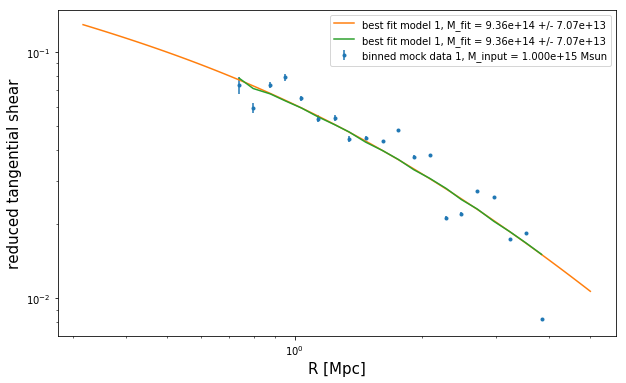

In [551]:
fig = plt.figure(figsize=(10, 6))

fig.gca().errorbar(profile['radius'], profile['gt'],profile['gt_err'],
                  label='binned mock data 1, M_input = %.3e Msun' % cluster_m, fmt='.')
fig.gca().plot(rr1, gt_model1,
               label='best fit model 1, M_fit = %.2e +/- %.2e' % (m_est, m_est_err))

fig.gca().plot(rr2, gt_model2,
               label='best fit model 1, M_fit = %.2e +/- %.2e' % (m_est, m_est_err))

plt.semilogx()
plt.semilogy()

plt.legend()
plt.xlabel('R [Mpc]', fontsize=fsize)
plt.ylabel('reduced tangential shear', fontsize=fsize)